In [1]:
from haystack import Pipeline, Document
from haystack.components.routers import ConditionalRouter
from haystack.components.builders.prompt_builder import PromptBuilder
from haystack.components.generators import OpenAIGenerator
from haystack.components.retrievers.in_memory import InMemoryBM25Retriever
from haystack.components.websearch.serper_dev import SerperDevWebSearch
from haystack.document_stores.in_memory import InMemoryDocumentStore

/Users/michieldekoninck/.pyenv/versions/3.10.6/envs/haystack_rag/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
documents = [Document(content="Retrievers: Retrieves relevant documents to a user query using keyword search or semantic search."),
             Document(content="Embedders: Creates embeddings for text or documents."),
             Document(content="Generators: Use a number of model providers to generate answers or content based on a prompt"),
             Document(content="File Converters: Converts different file types like TXT, Markdown, PDF, etc. into a Haystack Document type")]

document_store = InMemoryDocumentStore()
document_store.write_documents(documents=documents)

4

In [3]:
rag_prompt_template = """
Answer the following query given the documents.
If the answer is not contained within the documents, reply with 'no_answer'
Query: {{query}}
Documents:
{% for document in documents %}
  {{document.content}}
{% endfor %}
"""

In [5]:
from haystack_integrations.components.generators.ollama import OllamaGenerator

llm = OllamaGenerator(model="llama3.1:latest",
                            url = "http://localhost:11434",
                            generation_kwargs={
                              #"num_predict": 100,
                             # "temperature": 0.9,
                              })

In [6]:
rag = Pipeline()
rag.add_component("retriever", InMemoryBM25Retriever(document_store=document_store))
rag.add_component("prompt_builder", PromptBuilder(template=rag_prompt_template))
rag.add_component("llm", llm)

rag.connect("retriever.documents", "prompt_builder.documents")
rag.connect("prompt_builder", "llm")

🚅 Components
  - retriever: InMemoryBM25Retriever
  - prompt_builder: PromptBuilder
  - llm: OllamaGenerator
🛤️ Connections
  - retriever.documents -> prompt_builder.documents (List[Document])
  - prompt_builder.prompt -> llm.prompt (str)

In [7]:
query = "What is a retriever for?"

rag.run({"prompt_builder":{"query": query},
         "retriever": {"query": query}})

{'llm': {'replies': ['A retriever is for retrieving relevant documents to a user query using keyword search or semantic search.'],
  'meta': [{'model': 'llama3.1:latest',
    'created_at': '2024-10-02T14:02:06.041028Z',
    'done': True,
    'done_reason': 'stop',
    'context': [128006,
     882,
     128007,
     1432,
     16533,
     279,
     2768,
     3319,
     2728,
     279,
     9477,
     627,
     2746,
     279,
     4320,
     374,
     539,
     13282,
     2949,
     279,
     9477,
     11,
     10052,
     449,
     364,
     2201,
     29634,
     1270,
     2929,
     25,
     3639,
     374,
     264,
     10992,
     424,
     369,
     5380,
     28242,
     1473,
     220,
     38168,
     12601,
     25,
     15026,
     71647,
     369,
     1495,
     477,
     9477,
     382,
     220,
     20035,
     3078,
     25,
     49761,
     9959,
     9477,
     311,
     264,
     1217,
     3319,
     1701,
     16570,
     2778,
     477,
     42833,
     2778,

In [8]:
query = "What Mistral components are there?"

rag.run({"prompt_builder":{"query": query},
         "retriever": {"query": query}})

{'llm': {'replies': ["There are no documents provided. I'm ready to assist once you provide them."],
  'meta': [{'model': 'llama3.1:latest',
    'created_at': '2024-10-02T14:02:07.17502Z',
    'done': True,
    'done_reason': 'stop',
    'context': [128006,
     882,
     128007,
     1432,
     16533,
     279,
     2768,
     3319,
     2728,
     279,
     9477,
     627,
     2746,
     279,
     4320,
     374,
     539,
     13282,
     2949,
     279,
     9477,
     11,
     10052,
     449,
     364,
     2201,
     29634,
     1270,
     2929,
     25,
     3639,
     35198,
     3545,
     6956,
     527,
     1070,
     5380,
     28242,
     512,
     128009,
     128006,
     78191,
     128007,
     271,
     3947,
     527,
     912,
     9477,
     3984,
     13,
     358,
     2846,
     5644,
     311,
     7945,
     3131,
     499,
     3493,
     1124,
     13],
    'total_duration': 928858792,
    'load_duration': 27718209,
    'prompt_eval_count': 45,
    'promp

In [9]:
routes = [
    {
        "condition": "{{'no_answer' in replies[0]|lower}}",
        "output": "{{query}}",
        "output_name": "go_to_websearch",
        "output_type": str,
    },
    {
        "condition": "{{'no_answer' not in replies[0]|lower}}",
        "output": "{{replies[0]}}",
        "output_name": "answer",
        "output_type": str,
    },
]

In [11]:
router = ConditionalRouter(routes=routes)
router.run(replies=['Geoff is my friend'], query="Who is Geoff?")

{'answer': 'Geoff is my friend'}

In [12]:
router.run(replies=['No_answer'], query="Who is Geoff?")

{'go_to_websearch': 'Who is Geoff?'}

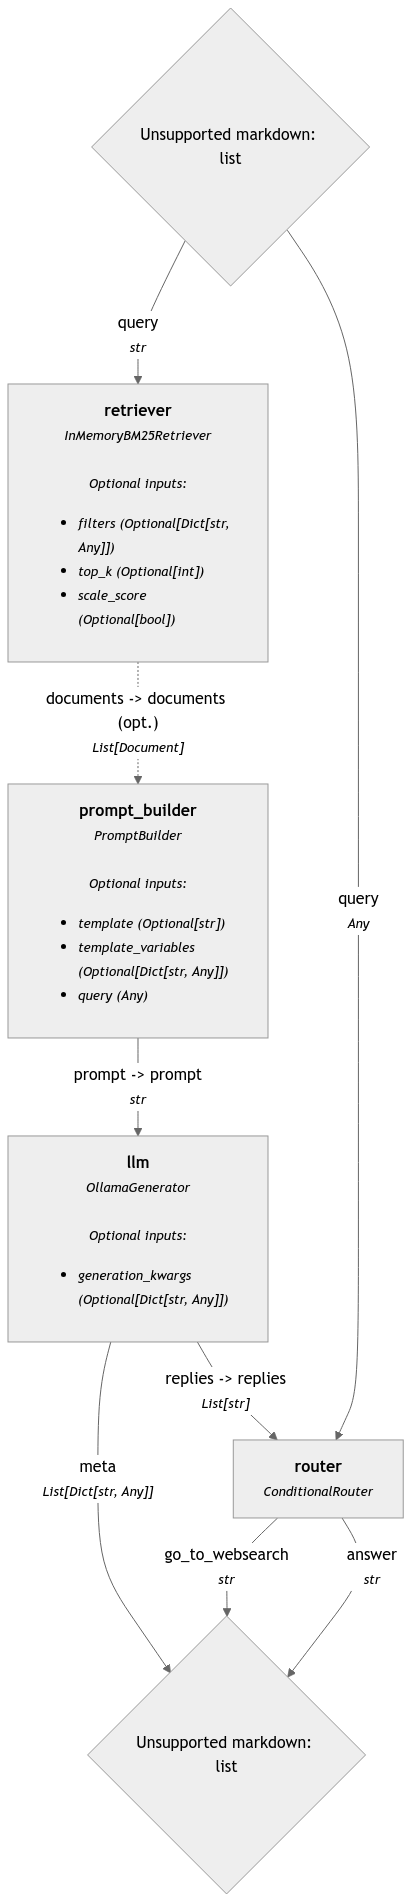

In [13]:
rag.add_component("router", ConditionalRouter(routes=routes))
rag.connect("llm.replies", "router.replies")

rag.show()

In [14]:
query = "What Mistral components does Haystack have?"

rag.run({"prompt_builder":{"query": query},
         "retriever": {"query": query},
         "router": {"query": query}})

{'llm': {'meta': [{'model': 'llama3.1:latest',
    'created_at': '2024-10-02T14:03:33.138003Z',
    'done': True,
    'done_reason': 'stop',
    'context': [128006,
     882,
     128007,
     1432,
     16533,
     279,
     2768,
     3319,
     2728,
     279,
     9477,
     627,
     2746,
     279,
     4320,
     374,
     539,
     13282,
     2949,
     279,
     9477,
     11,
     10052,
     449,
     364,
     2201,
     29634,
     1270,
     2929,
     25,
     3639,
     35198,
     3545,
     6956,
     1587,
     18276,
     7848,
     617,
     5380,
     28242,
     1473,
     220,
     2958,
     7316,
     388,
     25,
     42829,
     2204,
     1052,
     4595,
     1093,
     73529,
     11,
     74292,
     11,
     11612,
     11,
     5099,
     13,
     1139,
     264,
     18276,
     7848,
     12051,
     955,
     271,
     220,
     20035,
     3078,
     25,
     49761,
     9959,
     9477,
     311,
     264,
     1217,
     3319,
     1701,
     1

In [15]:
prompt_for_websearch = """
Answer the following query given the documents retrieved from the web.
Your answer should indicate that your answer was generated from websearch.
You can also reference the URLs that the answer was generated from

Query: {{query}}
Documents:
{% for document in documents %}
  {{document.content}}
{% endfor %}
"""

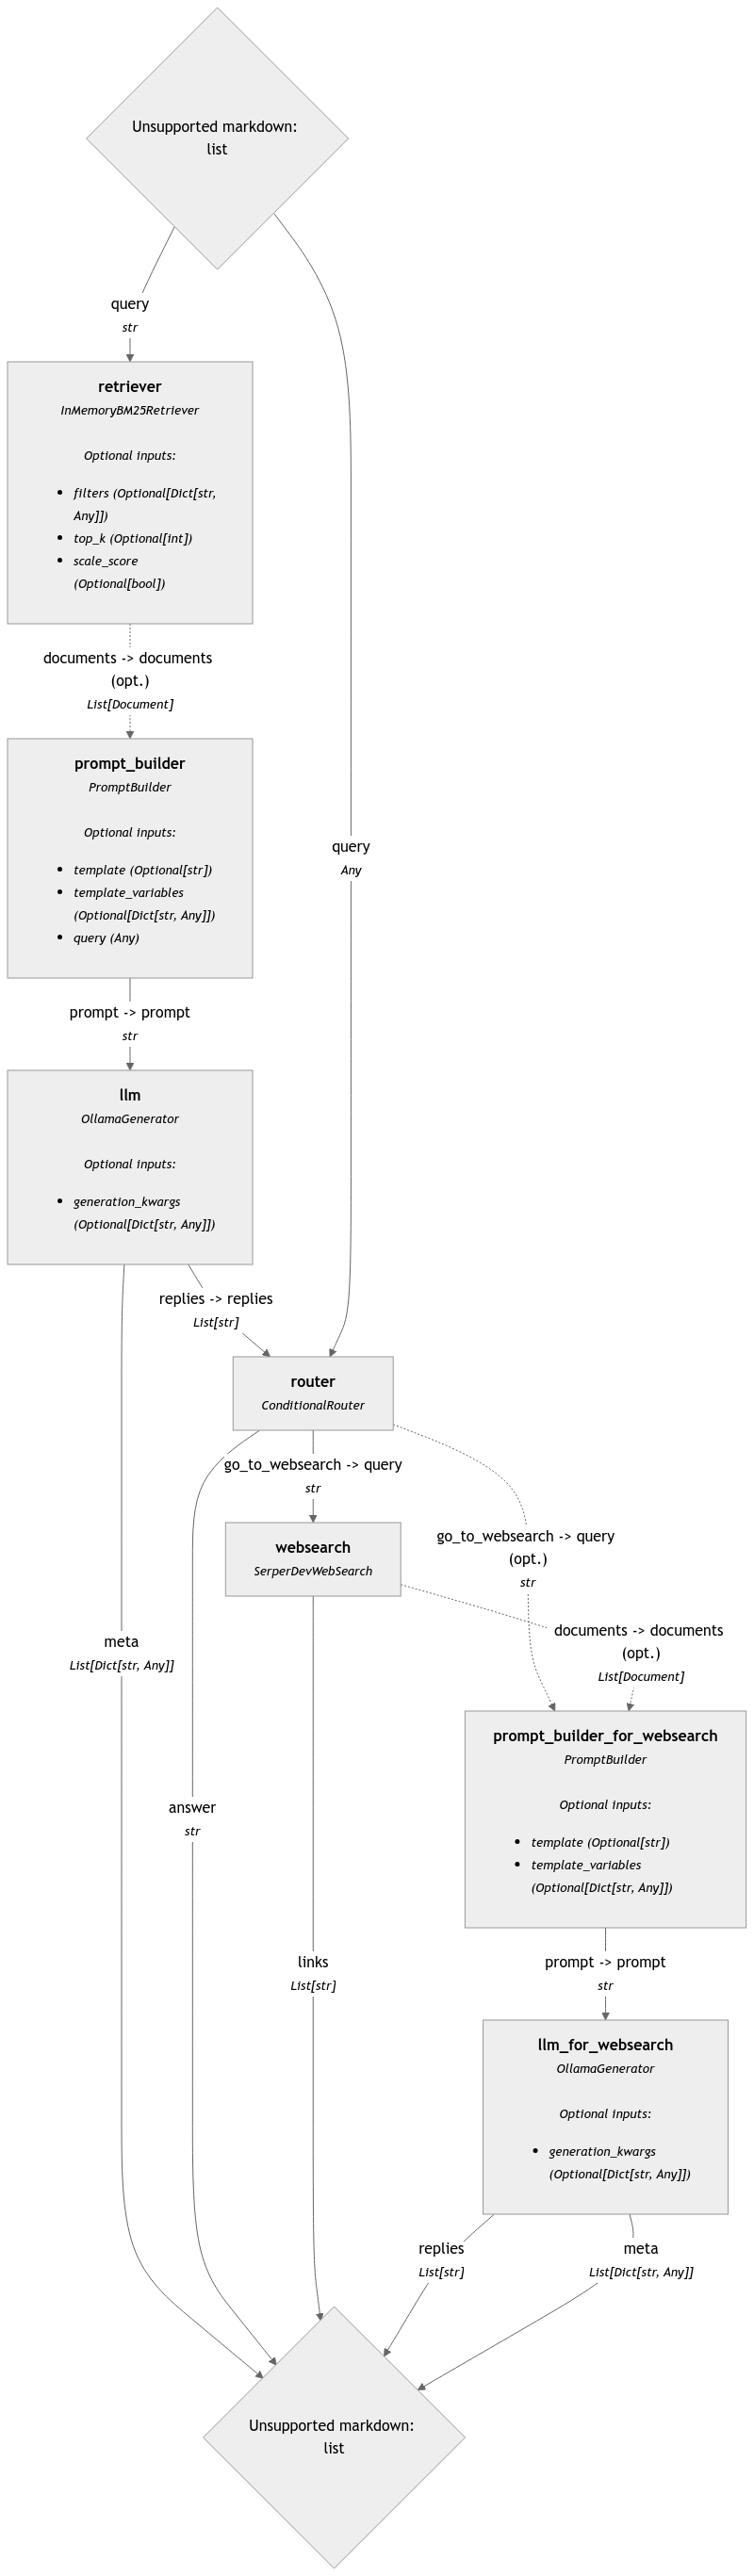

In [20]:
rag_or_websearch = Pipeline()
rag_or_websearch.add_component("retriever", InMemoryBM25Retriever(document_store=document_store))
rag_or_websearch.add_component("prompt_builder", PromptBuilder(template=rag_prompt_template))
rag_or_websearch.add_component("llm",OllamaGenerator(model="llama3.1:latest",
                            url = "http://localhost:11434"))
rag_or_websearch.add_component("router", ConditionalRouter(routes))
rag_or_websearch.add_component("websearch", SerperDevWebSearch())
rag_or_websearch.add_component("prompt_builder_for_websearch", PromptBuilder(template=prompt_for_websearch))
rag_or_websearch.add_component("llm_for_websearch",  OllamaGenerator(model="llama3.1:latest",
                            url = "http://localhost:11434"))

rag_or_websearch.connect("retriever", "prompt_builder.documents")
rag_or_websearch.connect("prompt_builder", "llm")
rag_or_websearch.connect("llm.replies", "router.replies")
rag_or_websearch.connect("router.go_to_websearch", "websearch.query")
rag_or_websearch.connect("router.go_to_websearch", "prompt_builder_for_websearch.query")
rag_or_websearch.connect("websearch.documents", "prompt_builder_for_websearch.documents")
rag_or_websearch.connect("prompt_builder_for_websearch", "llm_for_websearch")

rag_or_websearch.show()

In [21]:
query = "What Mistral components does Haystack have?"

rag_or_websearch.run({"prompt_builder":{"query": query},
                      "retriever": {"query": query},
                      "router": {"query": query}})

{'llm': {'meta': [{'model': 'llama3.1:latest',
    'created_at': '2024-10-02T14:05:16.781166Z',
    'done': True,
    'done_reason': 'stop',
    'context': [128006,
     882,
     128007,
     1432,
     16533,
     279,
     2768,
     3319,
     2728,
     279,
     9477,
     627,
     2746,
     279,
     4320,
     374,
     539,
     13282,
     2949,
     279,
     9477,
     11,
     10052,
     449,
     364,
     2201,
     29634,
     1270,
     2929,
     25,
     3639,
     35198,
     3545,
     6956,
     1587,
     18276,
     7848,
     617,
     5380,
     28242,
     1473,
     220,
     2958,
     7316,
     388,
     25,
     42829,
     2204,
     1052,
     4595,
     1093,
     73529,
     11,
     74292,
     11,
     11612,
     11,
     5099,
     13,
     1139,
     264,
     18276,
     7848,
     12051,
     955,
     271,
     220,
     20035,
     3078,
     25,
     49761,
     9959,
     9477,
     311,
     264,
     1217,
     3319,
     1701,
     1